In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import os
import copy

In [2]:
def get_images(directory: str, output_shape: tuple):
    assert len(output_shape) == 2
    # Read in pokemon images
    images = []
    for img in os.listdir(directory): 
        #print(os.path.join(DIR, img))
        image = cv2.imread(os.path.join(directory, img), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
        image = cv2.resize(image, dsize=output_shape)
        images.append(image)
    images = np.stack(images)
    return images

def set_transparency_from_RGBA(img: np.ndarray, transparency_color: tuple = (0,0,0)):
    assert len(img.shape) == 3
    assert img.shape[2] == 4
    assert len(transparency_color) == 3
    img = copy.deepcopy(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x][y][3] == 0:
                img[x][y][0] = transparency_color[0]
                img[x][y][1] = transparency_color[1]
                img[x][y][2] = transparency_color[2]
    return img

def convertRGBA2RGB(img: np.ndarray):
    assert len(img.shape) == 3
    assert img.shape[2] == 4
    img = copy.deepcopy(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    return img

def compress_color(img: np.ndarray, compression: int = 1):
    assert len(img.shape) == 3
    assert compression != 0
    img = copy.deepcopy(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x][y][0] != 255 and img[x][y][1] != 255 and img[x][y][2] != 255:
                img[x][y][0] = (img[x][y][0]//compression)*compression
                img[x][y][1] = (img[x][y][1]//compression)*compression
                img[x][y][2] = (img[x][y][2]//compression)*compression
    return img

def is_gray(r,g,b):
    return (r == g and g == b)

def is_black(r,g,b):
    return (r == 0 and g == 0 and b == 0)

def is_white(r,g,b):
    return (r == 255 and g == 255 and b == 255)

def get_color_dict(img: np.ndarray, compression: int = 1, omit_black: bool = True, omit_white: bool = True, omit_gray: bool = False):
    assert len(img.shape) == 3
    assert compression != 0
    img = copy.deepcopy(img)
    color_dict = {}
    total = 0
    for r in range(256//compression):
        for g in range(256//compression):
            for b in range(256//compression):
                color_dict[(r*compression, g*compression, b*compression)] = 0
    color_dict[(255,255,255)] = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            color = (img[x][y][0], img[x][y][1], img[x][y][2])
            if not ((omit_black and is_black(color[0],color[1],color[2])) or (omit_white and is_white(color[0],color[1],color[2])) or (omit_gray and is_gray(color[0],color[1],color[2]))):
                if color in color_dict:
                    color_dict[color] = color_dict[color] + 1
                    total = total + 1
    color_dict = {k: v for k, v in sorted(color_dict.items(), key=lambda item: item[1])}
    ret_dict = {'color_dict': color_dict, 'total': total}
    return ret_dict

def rgbtohex(r, g, b):
    return int('%02x%02x%02x'%(r,g,b), 16)

In [3]:
compression = 64
DIR = 'pokemon-stats-and-description-with-pictures-json/pokemons_images/pokemons/'
image_shape = (43,43)

In [4]:
images = get_images(DIR, image_shape)
for i in range(len(images)):
    img = set_transparency_from_RGBA(images[i])
    images[i] = img

In [5]:
temp_imgs = []
for i in range(len(images)):
    img = convertRGBA2RGB(images[i])
    temp_imgs.append(img)
images = np.stack(temp_imgs)

In [6]:
temp_imgs = []
for i in range(len(images)):
    img = compress_color(images[i],compression)
    temp_imgs.append(img)
images = np.stack(temp_imgs)

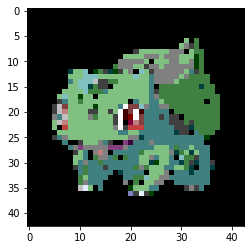

In [7]:
plt.imshow(images[0])

In [8]:
color_dicts = []
for i in range(len(images)):
    color_dict = get_color_dict(images[i],compression,omit_gray=True)
    color_dicts.append(color_dict)

In [9]:
dict_size = len(color_dicts[0]['color_dict'])
column_names = []
for r in range(256//compression):
    for g in range(256//compression):
        for b in range(256//compression):
            column_names.append(hex(rgbtohex(r*compression,g*compression,b*compression)))
if(column_names[-1] != hex(rgbtohex(255,255,255))):
    column_names.append(hex(rgbtohex(255,255,255)))

In [10]:
assert len(column_names) == dict_size

column_dict = {}
for name in column_names:
    new_column = []
    column_dict[name] = new_column
    
for color_dict in color_dicts:
    total = color_dict['total']
    cdict = color_dict['color_dict']
    for color, value in cdict.items():
        color_name = hex(rgbtohex(color[0],color[1],color[2]))
        column_dict[color_name].append(value/total)

In [11]:
data = pd.read_csv("pokemon_img_20by20_types.csv", index_col=0)
data = data.drop(data.columns.to_series()["p0000":"p1599"], axis=1)
for key, value in column_dict.items():
    data[key] = value

In [12]:
data

,id,name,species,type1,type2,gen,Normal,Fighting,Flying,Poison,...,0xc040c0,0xc08000,0xc08040,0xc08080,0xc080c0,0xc0c000,0xc0c040,0xc0c080,0xc0c0c0,0xffffff
0,1,Bulbasaur,Seed Pokemon,Grass,Poison,1,0,0,0,1,...,0.0,0.000000,0.000000,0.006814,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,2,Ivysaur,Seed Pokemon,Grass,Poison,1,0,0,0,1,...,0.0,0.000000,0.000000,0.052427,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,3,Venusaur,Seed Pokemon,Grass,Poison,1,0,0,0,1,...,0.0,0.000000,0.002469,0.086420,0.014815,0.0,0.000000,0.004938,0.0,0.0
3,4,Charmander,Lizard Pokemon,Fire,NaN,1,0,0,0,0,...,0.0,0.000000,0.417790,0.080863,0.002695,0.0,0.032345,0.099730,0.0,0.0
4,5,Charmeleon,Flame Pokemon,Fire,NaN,1,0,0,0,0,...,0.0,0.002857,0.097143,0.048571,0.000000,0.0,0.031429,0.082857,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,797,Celesteela,Launch Pokemon,Steel,Flying,7,0,0,1,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.018051,0.050542,0.0,0.0
797,798,Kartana,Drawn Sword Pokemon,Grass,Steel,7,0,0,0,0,...,0.0,0.040000,0.070000,0.000000,0.000000,0.1,0.030000,0.000000,0.0,0.0
798,799,Guzzlord,Junkivore Pokemon,Dark,Dragon,7,0,0,0,0,...,0.0,0.009662,0.033816,0.000000,0.000000,0.0,0.173913,0.024155,0.0,0.0
799,800,Necrozma,Prism Pokemon,Psychic,NaN,7,0,0,0,0,...,0.0,0.000000,0.000000,0.150000,0.000000,0.0,0.000000,0.150000,0.0,0.0


In [13]:
DIR = "gen8/"

In [14]:
images = get_images(DIR, image_shape)

In [15]:
for i in range(len(images)):
    img = set_transparency_from_RGBA(images[i])
    images[i] = img

In [16]:
temp_imgs = []
for i in range(len(images)):
    img = convertRGBA2RGB(images[i])
    temp_imgs.append(img)
images = np.stack(temp_imgs)

In [17]:
temp_imgs = []
for i in range(len(images)):
    img = compress_color(images[i],compression)
    temp_imgs.append(img)
images = np.stack(temp_imgs)

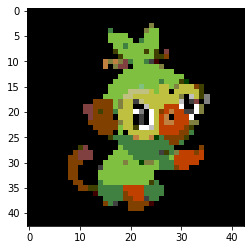

In [18]:
plt.imshow(images[0])

In [19]:
color_dicts = []
for i in range(len(images)):
    color_dict = get_color_dict(images[i],compression, omit_gray=True)
    color_dicts.append(color_dict)

In [20]:
dict_size = len(color_dicts[0]['color_dict'])
column_names = []
for r in range(256//compression):
    for g in range(256//compression):
        for b in range(256//compression):
            column_names.append(hex(rgbtohex(r*compression,g*compression,b*compression)))
if(column_names[-1] != hex(rgbtohex(255,255,255))):
    column_names.append(hex(rgbtohex(255,255,255)))

In [21]:
assert len(column_names) == dict_size

column_dict = {}
for name in column_names:
    new_column = []
    column_dict[name] = new_column
    
for color_dict in color_dicts:
    total = color_dict['total']
    cdict = color_dict['color_dict']
    for color, value in cdict.items():
        color_name = hex(rgbtohex(color[0],color[1],color[2]))
        column_dict[color_name].append(value/total)

In [22]:
trainX = data.loc[:, '0x0':]
trainYs = data.loc[:, 'Normal':'Fairy']
testX = trainX.iloc[0:0]
for key, value in column_dict.items():
    testX[key] = value

c:\users\brand\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
trainX

,0x0,0x40,0x80,0xc0,0x4000,0x4040,0x4080,0x40c0,0x8000,0x8040,...,0xc040c0,0xc08000,0xc08040,0xc08080,0xc080c0,0xc0c000,0xc0c040,0xc0c080,0xc0c0c0,0xffffff
0,0.0,0.000000,0.0,0.0,0.018739,0.027257,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.006814,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.011650,0.0,0.0,0.005825,0.083495,0.011650,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.052427,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.004938,0.0,0.0,0.034568,0.148148,0.022222,0.0,0.0,0.00000,...,0.0,0.000000,0.002469,0.086420,0.014815,0.0,0.000000,0.004938,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.002695,0.002695,0.0,0.0,0.00000,...,0.0,0.000000,0.417790,0.080863,0.002695,0.0,0.032345,0.099730,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.002857,0.097143,0.048571,0.000000,0.0,0.031429,0.082857,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,0.003610,0.0,0.0,0.086643,0.194946,0.000000,0.0,0.0,0.00722,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.018051,0.050542,0.0,0.0
797,0.0,0.000000,0.0,0.0,0.000000,0.010000,0.000000,0.0,0.0,0.00000,...,0.0,0.040000,0.070000,0.000000,0.000000,0.1,0.030000,0.000000,0.0,0.0
798,0.0,0.144928,0.0,0.0,0.000000,0.096618,0.043478,0.0,0.0,0.00000,...,0.0,0.009662,0.033816,0.000000,0.000000,0.0,0.173913,0.024155,0.0,0.0
799,0.0,0.000000,0.0,0.0,0.000000,0.050000,0.000000,0.0,0.0,0.00000,...,0.0,0.000000,0.000000,0.150000,0.000000,0.0,0.000000,0.150000,0.0,0.0


In [24]:
trainYs

,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
797,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
799,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [25]:
testX

,0x0,0x40,0x80,0xc0,0x4000,0x4040,0x4080,0x40c0,0x8000,0x8040,...,0xc040c0,0xc08000,0xc08040,0xc08080,0xc080c0,0xc0c000,0xc0c040,0xc0c080,0xc0c0c0,0xffffff
0,0.0,0.000000,0.000000,0.0,0.006000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.018000,0.000000,0.000000,0.0,0.118000,0.014000,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.025641,0.000000,0.0,0.0,0.009615,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.400641,0.048077,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.246512,0.037209,0.000000,0.0,0.0,0.516279,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.100917,0.009174,0.000000,0.0,0.110092,0.036697,0.0,0.0
4,0.0,0.005495,0.000000,0.0,0.000000,0.043956,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.016484,0.000000,0.000000,0.0,0.087912,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.013937,0.000000,0.0,0.000000,0.128920,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.020906,0.000000,0.0,0.010453,0.059233,0.0,0.0
77,0.0,0.015982,0.000000,0.0,0.000000,0.066210,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.006849,0.002283,0.0,0.002283,0.031963,0.0,0.0
78,0.0,0.017429,0.000000,0.0,0.000000,0.119826,0.037037,0.0,0.0,0.000000,...,0.0,0.0,0.082789,0.026144,0.000000,0.0,0.000000,0.004357,0.0,0.0
79,0.0,0.327032,0.039698,0.0,0.000000,0.001890,0.005671,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.005671,0.000000,0.0,0.000000,0.000000,0.0,0.0


We need to hyper tune each classifier to maximize probability in correct cases and minimize probability in incorrect cases.

In [26]:
types = trainYs.columns.tolist()
types

['Normal',
 'Fighting',
 'Flying',
 'Poison',
 'Ground',
 'Rock',
 'Bug',
 'Ghost',
 'Steel',
 'Fire',
 'Water',
 'Grass',
 'Electric',
 'Psychic',
 'Ice',
 'Dragon',
 'Dark',
 'Fairy']

In [27]:
gen8_types_data = pd.read_csv('gen8_types.csv', index_col=0)
gen8_types_data = gen8_types_data.loc[:,'Normal':'Fairy']
gen8_types_data

,Normal,Fighting,Flying,Poison,Ground,Rock,Bug,Ghost,Steel,Fire,Water,Grass,Electric,Psychic,Ice,Dragon,Dark,Fairy
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
77,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
79,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
from xgboost import XGBClassifier 

In [30]:
max_depth = [2,3,4,5,6,7,8,9,10,12,14,15,16,18,20,22,24,26,27,28,30,None]
colsample_bylevel = [0.1,0.5,0.9,None]
colsample_bynode = [0.1,0.5,0.9,None]
colsample_bytree = [0.1,0.5,0.9,None]
min_child_weight = [1,5,100,None]
reg_lambda = [1,5,100,None]
reg_alpha = [1,5,100,None]
n_estimators = [10,50,100,200]
learning_rate = [0.1,0.3,0.5]

best_classifiers = []

for t in types:
    best_clf = None
    name = t
    weight = len(data.loc[data[name] == 0]) / len(data.loc[data[name] == 1])
    true_labels = gen8_types_data[name]
    pos_weight = len(gen8_types_data.loc[gen8_types_data[name] == 0]) / len(gen8_types_data.loc[gen8_types_data[name] == 1])

    best_d = "Default"
    best_score = None
    for d in max_depth:
        xgb = XGBClassifier(max_depth=d, n_jobs=4, scale_pos_weight=weight, random_state=24)
        xgb.fit(trainX, trainYs[name])
        pred = xgb.predict_proba(testX)
        true_labels = gen8_types_data[name]
        score = 0
        for i in range(len(true_labels)):
            if(true_labels[i] == 1):
                # Reward a correct prediction
                # Use weight so reward has same value as punish
                score += pred[i][1] * pos_weight
            else:
                # Punish a false prediction
                score -= pred[i][1]
        if best_d == "Default" or best_score < score:
            best_d = d
            best_score = score
            best_clf = xgb

    print("Best d for %s: %d with score %f"%(name, best_d, best_score))
    
    best_csl = "Default"
    best_csn = "Default"
    best_cst = "Default"
    for csl in colsample_bylevel:
        for csn in colsample_bynode:
            for cst in colsample_bytree:
                xgb = XGBClassifier(max_depth=best_d,
                                    colsample_bylevel=csl,
                                    colsample_bynode=csn,
                                    colsample_bytree=cst,
                                    n_jobs=4,
                                    scale_pos_weight=weight, 
                                    random_state=24)
                xgb.fit(trainX, trainYs[name])
                pred = xgb.predict_proba(testX)
                true_labels = gen8_types_data[name]
                score = 0
                for i in range(len(true_labels)):
                    if(true_labels[i] == 1):
                        score += pred[i][1] * pos_weight
                    else:
                        score -= pred[i][1]
                if best_score < score:
                    best_csl = csl
                    best_csn = csn
                    best_cst = cst
                    best_score = score
                    best_clf = xgb
    print("Best csl, csn, cst for %s: %s, %s, %s with score %f"%(name, str(best_csl), str(best_csn),  str(best_cst), best_score))
    
    best_mcw = "Default"
    best_l = "Default"
    best_a = "Default"
    for mcw in min_child_weight:
        for l in reg_lambda:
            for a in reg_alpha:
                if type(best_csl) != str:
                    xgb = XGBClassifier(max_depth=best_d,
                                        colsample_bylevel=best_csl,
                                        colsample_bynode=best_csn,
                                        colsample_bytree=best_cst,
                                        min_child_weight=mcw,
                                        reg_lambda=l,
                                        reg_alpha=a,
                                        scale_pos_weight=weight, 
                                        random_state=24)
                else:
                    xgb = XGBClassifier(max_depth=best_d,
                                        min_child_weight=mcw,
                                        reg_lambda=l,
                                        reg_alpha=a,
                                        scale_pos_weight=weight, 
                                        random_state=24)
                xgb.fit(trainX, trainYs[name])
                pred = xgb.predict_proba(testX)
                true_labels = gen8_types_data[name]
                score = 0
                for i in range(len(true_labels)):
                    if(true_labels[i] == 1):
                        score += pred[i][1] * pos_weight
                    else:
                        score -= pred[i][1]
                if best_score < score:
                    best_mcw = mcw
                    best_l = l
                    best_a = a
                    best_score = score
                    best_clf = xgb
    print("Best mcw, l, a for %s: %s, %s, %s with score %f"%(name, str(best_mcw), str(best_l),  str(best_a), best_score))
    
    n_estimators = [10,50,100,200,300]
    learning_rate = [0.1,0.3,0.5,None]
    
    best_n = "Default"
    best_lr = "Default"
    for n in n_estimators:
        for lr in learning_rate:
            if type(best_csl) != str and type(best_mcw) != str:
                xgb = XGBClassifier(max_depth=best_d,
                                    colsample_bylevel=best_csl,
                                    colsample_bynode=best_csn,
                                    colsample_bytree=best_cst,
                                    min_child_weight=mcw,
                                    reg_lambda=l,
                                    reg_alpha=a,
                                    n_estimators=n,
                                    learning_rate=lr,
                                    n_jobs=4,
                                    scale_pos_weight=weight,
                                    random_state=24)
            elif type(best_csl) != str:
                xgb = XGBClassifier(max_depth=best_d,
                                    colsample_bylevel=best_csl,
                                    colsample_bynode=best_csn,
                                    colsample_bytree=best_cst,
                                    n_estimators=n,
                                    learning_rate=lr,
                                    n_jobs=4,
                                    scale_pos_weight=weight,
                                    random_state=24)
            else:
                xgb = XGBClassifier(max_depth=best_d,
                                    min_child_weight=mcw,
                                    reg_lambda=l,
                                    reg_alpha=a,
                                    n_estimators=n,
                                    learning_rate=lr,
                                    n_jobs=4,
                                    scale_pos_weight=weight,
                                    random_state=24)
            xgb.fit(trainX, trainYs[name])
            pred = xgb.predict_proba(testX)
            score = 0
            for i in range(len(true_labels)):
                if(true_labels[i] == 1):
                    score += pred[i][1] * pos_weight
                else:
                    score -= pred[i][1]
            if best_score < score:
                best_n = n
                best_lr = lr
                best_score = score
                best_clf = xgb
    print("Best n, lr for %s: %s, %s with score %f"%(name, str(best_n), str(best_lr), best_score))
    
    best_classifiers.append(best_clf)
    
    print()

Best d for Normal: 12 with score 21.336352
Best csl, csn, cst for Normal: 0.5, 0.1, 0.5 with score 27.007073
Best mcw, l, a for Normal: Default, Default, Default with score 27.007073
Best n, lr for Normal: Default, Default with score 27.007073

Best d for Fighting: 9 with score 5.021433
Best csl, csn, cst for Fighting: 0.9, None, 0.5 with score 9.759758
Best mcw, l, a for Fighting: Default, Default, Default with score 9.759758
Best n, lr for Fighting: 200, 0.3 with score 9.848648

Best d for Flying: 5 with score -4.212918
Best csl, csn, cst for Flying: 0.1, 0.1, 0.5 with score 2.249393
Best mcw, l, a for Flying: 5, 1, None with score 4.347575
Best n, lr for Flying: Default, Default with score 4.347575

Best d for Poison: 2 with score 37.244827
Best csl, csn, cst for Poison: 0.1, None, None with score 43.678539
Best mcw, l, a for Poison: Default, Default, Default with score 43.678539
Best n, lr for Poison: 50, 0.3 with score 44.767162

Best d for Ground: 3 with score 26.406292
Best csl,

In [31]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [32]:
for clf in best_classifiers:
    print(clf)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.5,
              colsample_bynode=0.1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=24, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=6.348623853211009, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints=None,
   

In [33]:
preds = []
for classifier in best_classifiers:
    preds.append(classifier.predict_proba(testX))

In [34]:
for i in range(len(testX)):
    pid = i + 810
    type_proba_dict = {}
    for j in range(len(preds)):
        type_proba_dict[types[j]] = preds[j][i][1] 
        type_proba_dict = {k: v for k, v in sorted(type_proba_dict.items(), key=lambda item: item[1])}
    print("Pid: " + str(pid))
    print(type_proba_dict)

Pid: 810
{'Water': 9.76529e-05, 'Fighting': 0.00031120275, 'Steel': 0.0009202325, 'Fire': 0.0062189046, 'Electric': 0.0063393787, 'Dragon': 0.024039183, 'Ghost': 0.026163721, 'Fairy': 0.054431543, 'Normal': 0.07369946, 'Dark': 0.13996455, 'Rock': 0.1551962, 'Ice': 0.15631002, 'Bug': 0.16860957, 'Ground': 0.24310996, 'Psychic': 0.31241295, 'Poison': 0.39817154, 'Grass': 0.5421306, 'Flying': 0.83416575}
Pid: 811
{'Water': 0.000509248, 'Fire': 0.0017405826, 'Steel': 0.004642194, 'Fairy': 0.013492646, 'Electric': 0.03541865, 'Normal': 0.06010902, 'Fighting': 0.062213864, 'Ghost': 0.07346933, 'Rock': 0.07475305, 'Bug': 0.098930776, 'Poison': 0.09920588, 'Ground': 0.16203888, 'Ice': 0.18037254, 'Psychic': 0.3412545, 'Grass': 0.41736892, 'Flying': 0.4230704, 'Dragon': 0.4931106, 'Dark': 0.49343175}
Pid: 812
{'Water': 0.00050584023, 'Fire': 0.0024895237, 'Fighting': 0.0031877235, 'Steel': 0.045890164, 'Psychic': 0.055819344, 'Poison': 0.0679225, 'Fairy': 0.07780034, 'Normal': 0.10535757, 'Ghos

In [35]:
type_avg_proba = {}
for i in range(len(gen8_types_data)):
    type_proba_dict = {}
    for j in range(len(preds)):
        type_proba_dict[types[j]] = preds[j][i][1] 
        type_proba_dict = {k: v for k, v in sorted(type_proba_dict.items(), key=lambda item: item[1])}
    print("Pid: " + str(i + 810))
    for t in types:
        if(gen8_types_data[t][i] == 1):
            print(t + ": " + str(type_proba_dict[t]))
            if t not in type_avg_proba:
                type_avg_proba[t] = []
            type_avg_proba[t].append(type_proba_dict[t])
    print(type_proba_dict)
    print()

Pid: 810
Grass: 0.5421306
{'Water': 9.76529e-05, 'Fighting': 0.00031120275, 'Steel': 0.0009202325, 'Fire': 0.0062189046, 'Electric': 0.0063393787, 'Dragon': 0.024039183, 'Ghost': 0.026163721, 'Fairy': 0.054431543, 'Normal': 0.07369946, 'Dark': 0.13996455, 'Rock': 0.1551962, 'Ice': 0.15631002, 'Bug': 0.16860957, 'Ground': 0.24310996, 'Psychic': 0.31241295, 'Poison': 0.39817154, 'Grass': 0.5421306, 'Flying': 0.83416575}

Pid: 811
Grass: 0.41736892
{'Water': 0.000509248, 'Fire': 0.0017405826, 'Steel': 0.004642194, 'Fairy': 0.013492646, 'Electric': 0.03541865, 'Normal': 0.06010902, 'Fighting': 0.062213864, 'Ghost': 0.07346933, 'Rock': 0.07475305, 'Bug': 0.098930776, 'Poison': 0.09920588, 'Ground': 0.16203888, 'Ice': 0.18037254, 'Psychic': 0.3412545, 'Grass': 0.41736892, 'Flying': 0.4230704, 'Dragon': 0.4931106, 'Dark': 0.49343175}

Pid: 812
Grass: 0.71092397
{'Water': 0.00050584023, 'Fire': 0.0024895237, 'Fighting': 0.0031877235, 'Steel': 0.045890164, 'Psychic': 0.055819344, 'Poison': 0.06

In [36]:
for t, value in type_avg_proba.items():
    print("# of " + t + ": " + str(len(type_avg_proba[t])))
    type_avg_proba[t] = sum(type_avg_proba[t])/len(type_avg_proba[t])
print("Average Probability of Actual Type (ie Correlation to color for gen 8)")
type_avg_proba = {k: v for k, v in sorted(type_avg_proba.items(), key=lambda item: item[1])}
print(type_avg_proba)

# of Grass: 8
# of Fire: 7
# of Water: 10
# of Normal: 6
# of Flying: 4
# of Steel: 5
# of Bug: 7
# of Psychic: 7
# of Dark: 7
# of Rock: 5
# of Electric: 8
# of Dragon: 10
# of Ground: 3
# of Poison: 3
# of Fighting: 5
# of Ghost: 7
# of Fairy: 6
# of Ice: 6
Average Probability of Actual Type (ie Correlation to color for gen 8)
{'Fighting': 0.15309877063264138, 'Dragon': 0.21992520187050105, 'Ghost': 0.24177199948046887, 'Steel': 0.2481835585087538, 'Fairy': 0.34314650235076744, 'Bug': 0.381731246731111, 'Electric': 0.3855420834443066, 'Psychic': 0.4049387192686221, 'Water': 0.47752389952074736, 'Dark': 0.48684038115399225, 'Flying': 0.4979913532733917, 'Rock': 0.499210923910141, 'Grass': 0.5241801366209984, 'Normal': 0.5658859858910242, 'Ground': 0.626669188340505, 'Ice': 0.6375879893700281, 'Poison': 0.7749849756558737, 'Fire': 0.864180496760777}


These scores are good, but this model is optimized specifically to predict for Gen 8. We must optimize with CV on the trainX and trainY. For test sets used in CV could be randomized, but I believe that it should be tested generation by generation (ie. if you train with gen 1-6, use gen 7 as the test).

In [37]:
from sklearn.model_selection import PredefinedSplit

In [38]:
data = pd.read_csv('pokemon_img_20by20_types.csv', index_col=0)
data = data['gen']
data

0      1
1      1
2      1
3      1
4      1
      ..
796    7
797    7
798    7
799    7
800    7
Name: gen, Length: 801, dtype: int64

In [39]:
test_fold = data - 1
test_fold = test_fold.to_list()
ps = PredefinedSplit(test_fold)
ps

PredefinedSplit(test_fold=array([0, 0, ..., 6, 6]))

In [40]:
max_depth = [2,3,4,5,6,7,8,9,10,12,14,15,16,18,20,22,24,26,27,28,30,None]
colsample_bylevel = [0.1,0.5,0.9,None]
colsample_bynode = [0.1,0.5,0.9,None]
colsample_bytree = [0.1,0.5,0.9,None]
min_child_weight = [1,5,100,None]
reg_lambda = [1,5,100,None]
reg_alpha = [1,5,100,None]
n_estimators = [10,50,100,200]
learning_rate = [0.1,0.3,0.5]

fit_params = {
    'max_depth' : max_depth,
    'colsample_bylevel': colsample_bylevel,
    'colsample_bynode': colsample_bynode,
    'colsample_bytree': colsample_bytree
}

reg_params = {
    'min_child_weight': min_child_weight,
    'reg_lambda': reg_lambda,
    'reg_alpha': reg_alpha
}

est_params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate
}

In [49]:
from sklearn.model_selection import GridSearchCV

In [55]:
best_classifiers = []

for t in types:
    best_clf = None
    best_score = 0
    name = t
    weight = (len(trainYs.loc[trainYs[name] == 0]) 
              / len(trainYs.loc[trainYs[name] == 1]))
    
    print("Optimizing Fitting")
    xgb = XGBClassifier(scale_pos_weight=weight, random_state=24)
    grid = GridSearchCV(xgb, 
                        fit_params, 
                        scoring='accuracy',
                        n_jobs=8,
                        cv=ps,
                        verbose=3)
    grid.fit(trainX, trainYs[name])
    if (grid.best_score_ > best_score):
        best_clf = grid.best_estimator_
    
    print("Optimizing Regularization")
    grid = GridSearchCV(best_clf, 
                        reg_params, 
                        scoring='accuracy',
                        n_jobs=8,
                        cv=ps,
                        verbose=3)
    grid.fit(trainX, trainYs[name])
    if (grid.best_score_ > best_score):
        best_clf = grid.best_estimator_
    
    print("Optimizing Estimators")
    grid = GridSearchCV(best_clf, 
                        est_params, 
                        scoring='accuracy',
                        n_jobs=8,
                        cv=ps,
                        verbose=3)
    grid.fit(trainX, trainYs[name])
    if (grid.best_score_ > best_score):
        best_clf = grid.best_estimator_
    
    best_classifiers.append(best_clf)

Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done 152 tasks      | elapsed:   16.3s
[Parallel(n_jobs=8)]: Done 472 tasks      | elapsed:   20.5s
[Parallel(n_jobs=8)]: Done 920 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 1496 tasks      | elapsed:   31.3s
[Parallel(n_jobs=8)]: Done 2200 tasks      | elapsed:   39.6s
[Parallel(n_jobs=8)]: Done 3032 tasks      | elapsed:   49.0s
[Parallel(n_jobs=8)]: Done 3992 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 5080 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 6296 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 7640 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 9112 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 9841 out of 9856 | elapsed:  3.2min remaining:    0.2s
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.2min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   21.8s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   16.0s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   15.6s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:   19.6s
[Parallel(n_jobs=8)]: Done 1424 tasks      | elapsed:   28.6s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:   43.2s
[Parallel(n_jobs=8)]: Done 3984 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 4944 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 5904 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 6992 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 8208 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 9552 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.0min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   15.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done 408 tasks      | elapsed:   20.0s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   20.4s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   14.4s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=8)]: Done 432 tasks      | elapsed:   19.2s
[Parallel(n_jobs=8)]: Done 880 tasks      | elapsed:   23.4s
[Parallel(n_jobs=8)]: Done 1456 tasks      | elapsed:   29.6s
[Parallel(n_jobs=8)]: Done 2160 tasks      | elapsed:   38.0s
[Parallel(n_jobs=8)]: Done 2992 tasks      | elapsed:   47.7s
[Parallel(n_jobs=8)]: Done 3952 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 5040 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 6256 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 7600 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 9048 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.2min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   19.3s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.3s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   15.2s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   16.2s
[Parallel(n_jobs=8)]: Done 408 tasks      | elapsed:   19.1s
[Parallel(n_jobs=8)]: Done 856 tasks      | elapsed:   23.3s
[Parallel(n_jobs=8)]: Done 1432 tasks      | elapsed:   29.3s
[Parallel(n_jobs=8)]: Done 2136 tasks      | elapsed:   37.5s
[Parallel(n_jobs=8)]: Done 2968 tasks      | elapsed:   46.9s
[Parallel(n_jobs=8)]: Done 3928 tasks      | elapsed:   60.0s
[Parallel(n_jobs=8)]: Done 5016 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 6232 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 7576 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 9048 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 9841 out of 9856 | elapsed:  2.9min remaining:    0.2s
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  2.9min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 120 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   20.1s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   15.6s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 160 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done 480 tasks      | elapsed:   18.2s
[Parallel(n_jobs=8)]: Done 928 tasks      | elapsed:   22.8s
[Parallel(n_jobs=8)]: Done 1504 tasks      | elapsed:   29.0s
[Parallel(n_jobs=8)]: Done 2208 tasks      | elapsed:   37.3s
[Parallel(n_jobs=8)]: Done 3040 tasks      | elapsed:   46.9s
[Parallel(n_jobs=8)]: Done 4000 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 5088 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 6304 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 7648 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 9120 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.0min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   18.3s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   14.1s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done 864 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done 1440 tasks      | elapsed:   27.6s
[Parallel(n_jobs=8)]: Done 2144 tasks      | elapsed:   35.8s
[Parallel(n_jobs=8)]: Done 2976 tasks      | elapsed:   45.3s
[Parallel(n_jobs=8)]: Done 3936 tasks      | elapsed:   58.8s
[Parallel(n_jobs=8)]: Done 5024 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 6240 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 7584 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 9056 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.0min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   18.3s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   15.4s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   14.6s
[Parallel(n_jobs=8)]: Done 424 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done 872 tasks      | elapsed:   21.9s
[Parallel(n_jobs=8)]: Done 1448 tasks      | elapsed:   28.3s
[Parallel(n_jobs=8)]: Done 2152 tasks      | elapsed:   36.9s
[Parallel(n_jobs=8)]: Done 2984 tasks      | elapsed:   46.5s
[Parallel(n_jobs=8)]: Done 3944 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 5032 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 6248 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 7592 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 9064 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.1min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done 344 tasks      | elapsed:   19.6s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   21.6s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   16.0s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   13.7s
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:   16.5s
[Parallel(n_jobs=8)]: Done 864 tasks      | elapsed:   20.8s
[Parallel(n_jobs=8)]: Done 1440 tasks      | elapsed:   26.8s
[Parallel(n_jobs=8)]: Done 2144 tasks      | elapsed:   34.9s
[Parallel(n_jobs=8)]: Done 2976 tasks      | elapsed:   44.2s
[Parallel(n_jobs=8)]: Done 3936 tasks      | elapsed:   57.2s
[Parallel(n_jobs=8)]: Done 5024 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 6240 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 7584 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 9056 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  2.8min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   15.6s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   19.1s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.5s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   13.4s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 432 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done 880 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done 1456 tasks      | elapsed:   27.5s
[Parallel(n_jobs=8)]: Done 2160 tasks      | elapsed:   35.5s
[Parallel(n_jobs=8)]: Done 2992 tasks      | elapsed:   44.7s
[Parallel(n_jobs=8)]: Done 3952 tasks      | elapsed:   57.5s
[Parallel(n_jobs=8)]: Done 5040 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 6256 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 7600 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 9072 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  2.8min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.9s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   16.8s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   15.7s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 120 tasks      | elapsed:   12.8s
[Parallel(n_jobs=8)]: Done 440 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done 888 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done 1464 tasks      | elapsed:   27.1s
[Parallel(n_jobs=8)]: Done 2168 tasks      | elapsed:   35.3s
[Parallel(n_jobs=8)]: Done 3000 tasks      | elapsed:   45.3s
[Parallel(n_jobs=8)]: Done 3960 tasks      | elapsed:   58.8s
[Parallel(n_jobs=8)]: Done 5048 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 6264 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 7608 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 9080 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 9841 out of 9856 | elapsed:  2.9min remaining:    0.2s
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  2.9min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:   17.5s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   17.9s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.6s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   14.8s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done 448 tasks      | elapsed:   18.2s
[Parallel(n_jobs=8)]: Done 896 tasks      | elapsed:   22.7s
[Parallel(n_jobs=8)]: Done 1472 tasks      | elapsed:   29.3s
[Parallel(n_jobs=8)]: Done 2176 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 3008 tasks      | elapsed:   48.7s
[Parallel(n_jobs=8)]: Done 3968 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 5056 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 6272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 7616 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 9088 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.3min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   21.6s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   15.6s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 432 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 880 tasks      | elapsed:   22.8s
[Parallel(n_jobs=8)]: Done 1456 tasks      | elapsed:   29.1s
[Parallel(n_jobs=8)]: Done 2160 tasks      | elapsed:   37.7s
[Parallel(n_jobs=8)]: Done 2992 tasks      | elapsed:   47.5s
[Parallel(n_jobs=8)]: Done 3952 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 5040 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 6256 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 7600 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 9072 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.0min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   17.8s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   15.2s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 120 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 440 tasks      | elapsed:   18.6s
[Parallel(n_jobs=8)]: Done 888 tasks      | elapsed:   22.9s
[Parallel(n_jobs=8)]: Done 1464 tasks      | elapsed:   29.2s
[Parallel(n_jobs=8)]: Done 2168 tasks      | elapsed:   37.4s
[Parallel(n_jobs=8)]: Done 3000 tasks      | elapsed:   46.9s
[Parallel(n_jobs=8)]: Done 3960 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 5048 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 6264 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 7608 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 9080 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 9841 out of 9856 | elapsed:  2.9min remaining:    0.2s
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  2.9min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   18.6s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   12.3s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 424 tasks      | elapsed:   20.1s
[Parallel(n_jobs=8)]: Done 872 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 1448 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done 2152 tasks      | elapsed:   39.5s
[Parallel(n_jobs=8)]: Done 2984 tasks      | elapsed:   49.6s
[Parallel(n_jobs=8)]: Done 3944 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 5032 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 6248 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 7592 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 9064 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 9841 out of 9856 | elapsed:  3.3min remaining:    0.2s
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.3min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 144 tasks      | elapsed:   17.1s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   20.7s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   13.4s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done 344 tasks      | elapsed:   21.0s
[Parallel(n_jobs=8)]: Done 792 tasks      | elapsed:   27.7s
[Parallel(n_jobs=8)]: Done 1368 tasks      | elapsed:   35.4s
[Parallel(n_jobs=8)]: Done 2072 tasks      | elapsed:   45.4s
[Parallel(n_jobs=8)]: Done 2904 tasks      | elapsed:   56.8s
[Parallel(n_jobs=8)]: Done 3864 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 4952 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 6168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 7512 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 8984 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.2min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   15.6s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   19.6s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.8s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   14.1s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   12.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 424 tasks      | elapsed:   17.8s
[Parallel(n_jobs=8)]: Done 872 tasks      | elapsed:   22.7s
[Parallel(n_jobs=8)]: Done 1448 tasks      | elapsed:   29.8s
[Parallel(n_jobs=8)]: Done 2152 tasks      | elapsed:   39.2s
[Parallel(n_jobs=8)]: Done 2984 tasks      | elapsed:   49.7s
[Parallel(n_jobs=8)]: Done 3944 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 5032 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 6248 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 7592 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 9064 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.2min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.6s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   15.8s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   20.5s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   14.3s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done 128 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done 448 tasks      | elapsed:   18.7s
[Parallel(n_jobs=8)]: Done 896 tasks      | elapsed:   23.5s
[Parallel(n_jobs=8)]: Done 1472 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 2176 tasks      | elapsed:   40.0s
[Parallel(n_jobs=8)]: Done 3008 tasks      | elapsed:   50.7s
[Parallel(n_jobs=8)]: Done 3968 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 5056 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 6272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 7616 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 9088 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.3min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   20.2s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   23.9s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   16.3s finished


Optimizing Fitting
Fitting 7 folds for each of 1408 candidates, totalling 9856 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 392 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 840 tasks      | elapsed:   24.3s
[Parallel(n_jobs=8)]: Done 1416 tasks      | elapsed:   32.2s
[Parallel(n_jobs=8)]: Done 2120 tasks      | elapsed:   42.7s
[Parallel(n_jobs=8)]: Done 2952 tasks      | elapsed:   54.9s
[Parallel(n_jobs=8)]: Done 3912 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 5000 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 6216 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 7560 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 9032 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 9856 out of 9856 | elapsed:  3.5min finished


Optimizing Regularization
Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done 448 out of 448 | elapsed:   19.9s finished


Optimizing Estimators
Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.9s
[Parallel(n_jobs=8)]: Done  84 out of  84 | elapsed:   13.3s finished


In [56]:
preds = []
for classifier in best_classifiers:
    preds.append(classifier.predict_proba(testX))

In [63]:
for i in range(len(testX)):
    pid = i + 810
    type_proba_dict = {}
    for j in range(len(preds)):
        type_proba_dict[types[j]] = preds[j][i][1] 
        type_proba_dict = {k: v for k, v in sorted(type_proba_dict.items(), key=lambda item: item[1])}
    print("Pid: " + str(pid))
    print(type_proba_dict)

Pid: 810
{'Steel': 6.956979e-05, 'Dark': 0.00031586122, 'Ice': 0.0010524853, 'Water': 0.0026022978, 'Poison': 0.0039965864, 'Electric': 0.006198581, 'Normal': 0.008579115, 'Fire': 0.016393173, 'Dragon': 0.018374573, 'Fairy': 0.040206667, 'Ground': 0.09122886, 'Grass': 0.09988378, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}
Pid: 811
{'Steel': 1.7191524e-05, 'Fire': 0.0005022505, 'Ice': 0.0007520982, 'Water': 0.0021558662, 'Normal': 0.009492574, 'Grass': 0.012062146, 'Dark': 0.014963193, 'Electric': 0.015069925, 'Poison': 0.030847315, 'Ground': 0.055849396, 'Fairy': 0.058275666, 'Dragon': 0.11681044, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}
Pid: 812
{'Dark': 0.00011198127, 'Steel': 0.00035972154, 'Normal': 0.0011900023, 'Fire': 0.002305712, 'Water': 0.005089179, 'Poison': 0.01138881, 'Ice': 0.013747725, 'Electric': 0.022101749, 'Grass': 0.06090944, 'Dragon': 0.17753546, 'Fairy': 0.19544278, 'Ground':

In [66]:
type_avg_proba = {}
for i in range(len(gen8_types_data)):
    type_proba_dict = {}
    for j in range(len(preds)):
        type_proba_dict[types[j]] = preds[j][i][1] 
        type_proba_dict = {k: v for k, v in sorted(type_proba_dict.items(), key=lambda item: item[1])}
    print("Pid: " + str(i + 810))
    for t in types:
        if(gen8_types_data[t][i] == 1):
            print(t + ": " + str(type_proba_dict[t]))
            if t not in type_avg_proba:
                type_avg_proba[t] = []
            type_avg_proba[t].append(type_proba_dict[t])
    print(type_proba_dict)
    print()

Pid: 810
Grass: 0.09988378
{'Steel': 6.956979e-05, 'Dark': 0.00031586122, 'Ice': 0.0010524853, 'Water': 0.0026022978, 'Poison': 0.0039965864, 'Electric': 0.006198581, 'Normal': 0.008579115, 'Fire': 0.016393173, 'Dragon': 0.018374573, 'Fairy': 0.040206667, 'Ground': 0.09122886, 'Grass': 0.09988378, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}

Pid: 811
Grass: 0.012062146
{'Steel': 1.7191524e-05, 'Fire': 0.0005022505, 'Ice': 0.0007520982, 'Water': 0.0021558662, 'Normal': 0.009492574, 'Grass': 0.012062146, 'Dark': 0.014963193, 'Electric': 0.015069925, 'Poison': 0.030847315, 'Ground': 0.055849396, 'Fairy': 0.058275666, 'Dragon': 0.11681044, 'Fighting': 0.5, 'Flying': 0.5, 'Rock': 0.5, 'Bug': 0.5, 'Ghost': 0.5, 'Psychic': 0.5}

Pid: 812
Grass: 0.06090944
{'Dark': 0.00011198127, 'Steel': 0.00035972154, 'Normal': 0.0011900023, 'Fire': 0.002305712, 'Water': 0.005089179, 'Poison': 0.01138881, 'Ice': 0.013747725, 'Electric': 0.022101749, 'Grass': 0.06090

In [67]:
for t, value in type_avg_proba.items():
    type_avg_proba[t] = sum(type_avg_proba[t])/len(type_avg_proba[t])
print("Average Probability of Actual Type (ie Correlation to color for gen 8)")
type_avg_proba = {k: v for k, v in sorted(type_avg_proba.items(), key=lambda item: item[1])}
#print(type_avg_proba)
for key, val in type_avg_proba.items():
    print("%s: %f"%(key,val))

Average Probability of Actual Type (ie Correlation to color for gen 8)
Dragon: 0.006238
Dark: 0.030336
Steel: 0.036083
Ice: 0.068223
Electric: 0.079489
Grass: 0.081027
Fairy: 0.160756
Normal: 0.215497
Water: 0.263060
Ground: 0.299434
Poison: 0.348868
Flying: 0.500000
Bug: 0.500000
Psychic: 0.500000
Rock: 0.500000
Fighting: 0.500000
Ghost: 0.500000
Fire: 0.607450


In [68]:
for i in range(len(best_classifiers)):
    print(types[i])
    print(best_classifiers[i])

Normal
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.9,
              colsample_bynode=0.9, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=24, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=6.348623853211009, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Fighting
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=No